In [1]:
import sys
!{sys.executable} -m pip uninstall smi-analysis --yes
!{sys.executable} -m pip install git+https://github.com/gfreychet/smi-analysis.git

Found existing installation: smi-analysis 0.1.0.post70+g87cab36
Uninstalling smi-analysis-0.1.0.post70+g87cab36:
  Successfully uninstalled smi-analysis-0.1.0.post70+g87cab36
  Cloning https://github.com/gfreychet/smi-analysis.git to c:\users\at280565\appdata\local\temp\pip-req-build-kb110gnz
  Resolved https://github.com/gfreychet/smi-analysis.git to commit 87cab36948499bc82bfef49101843bfc13014bb7
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for smi-analysis: started
  Running setup.py install for smi-analysis: finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/gfreychet/smi-analysis.git 'C:\Users\AT280565\AppData\Local\Temp\pip-req-build-kb110gnz'
  DEPRECATION: smi-analysis is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\dev\sw\envs3\env_metrocarac\Scripts\python.exe -m pip install --upgrade pip


# Importing the package
Since the package is not available via pip, you have to specify where you downloaded the data_treatment.py file in the module_path variable

In [2]:
import importlib.util

module_path = "C:\\Users\\AT280565\\PycharmProjects\\EdfToHdf5\\edf2NxSAS\\edf2nxsas\\data_treatment.py"
spec = importlib.util.spec_from_file_location("data_treatment", module_path)
data_treatment = importlib.util.module_from_spec(spec)
sys.modules["data_treatment"] = data_treatment
spec.loader.exec_module(data_treatment)

NexusFile = data_treatment.NexusFile

# Important note

As you'll see througout this notebook, all the cells start with nx_file = NexusFile(file_path) and end with nx_file.close(), this is really important if you want your file to be opened and closed properly, using the H5PY librairy to directly open a filem ight lead to some errors.
You've been warned.

# Visualize the structure of the .h5 file with NeXus standard

The first step is to visualize the structure of the file and all the data / metadata it contains.
There are three types of element :

    - Groups (red) : you can view them as a directory, it can contain other groups or dataset and has attributes
    - Datasets (blue) : you can view them as a file, it can have attributes
    - Attributes (green) : you can view them as properties. They don't contain anything and they're additional info
    
To visualize the structure of your .h5,you just have to change the absolute path of the .h5 file you want to use. Don't forget to put two "\" if you use them, if you use "/" no modification is necessary. It is the only variable you need to change here

In [3]:
%matplotlib notebook

import os
import h5py
from colorama import Fore, Style
import matplotlib.pyplot as plt
import numpy as np
from smi_analysis import SMI_beamline


file_path = "C:\\Users\\AT280565\\PycharmProjects\\EdfToHdf5\\edf2NxSAS\\treated data\\instrument - Xeuss\\config - 2024-12-19T15-00\\sample - SafeLiMove\\experiment - SAXS\\format - NXsas\defaultSampleName_SAXS_2025-01-07T15-25-29.h5"



def explore_file(group, level=0):
    indent = "|  " * level
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            print(f"{indent}{Fore.RED}Group : {key}{Style.RESET_ALL}")
            explore_file(item, level + 1)
        elif isinstance(item, h5py.Dataset):
            print(f"{indent}{Fore.CYAN}Dataset : {key}{Style.RESET_ALL}")
            if item.attrs:
                print(f"{indent}  {Fore.GREEN}Attributes : {key}{Style.RESET_ALL}")
                for key_attribute, item_attribute in item.attrs.items():
                    print(f"{indent}    - {key_attribute} : {item_attribute}")
            
nx_file = NexusFile(file_path)
file = nx_file.get_file()
explore_file(file)
nx_file.close()

Group : ENTRY
|  Group : DATA
|  |  Dataset : I
|  |    Attributes : I
|  |      - EX_required : True
|  |      - docstring : Array of I measured.
|  |      - scaling_factor : I_scaling
|  |      - type : NX_NUMBER
|  |      - uncertainties : Idev
|  |      - units : arbitrary
|  |  Dataset : Idev
|  |    Attributes : Idev
|  |      - EX_required : True
|  |      - docstring : Array of I's uncertainties.
|  |      - type : NX_NUMBER
|  |      - units : arbitrary
|  |  Dataset : R
|  |    Attributes : R
|  |      - EX_required : True
|  |      - docstring : Array of R (positions), can be an array of 3D vector or an array of scalar representing |R|
|  |      - resolutions : dRl, dRw
|  |      - resolutions_description : Gaussian
|  |      - type : NX_NUMBER
|  |      - uncertainties : Rdev
|  |      - units : nm
|  |  Dataset : Rdev
|  |    Attributes : Rdev
|  |      - EX_required : False
|  |      - docstring : Array of R's uncertainties'
|  |      - type : NX_NUMBER
|  |      - units 

# Extract a dataset into a python variable

If you want to extract a dataset or one of it's attribute (for example the wavelength and it's unit) you simply have to follow the folowing model :

In [4]:
# Open your file using the NexusFile class
nx_file = NexusFile(file_path)

# Extract the value of a dataset using this method
wavelength = nx_file.extract_from_h5(path="ENTRY/INSTRUMENT/SOURCE/incident_wavelength", data_type="dataset", attribute_name=None)
# other example with the sample-detector distance 
SDD = nx_file.extract_from_h5(path="ENTRY/INSTRUMENT/DETECTOR/SDD", data_type="dataset", attribute_name=None)

# Extract an attribute using this verion of the method
unit_wavelength = nx_file.extract_from_h5(path="ENTRY/INSTRUMENT/SOURCE/incident_wavelength", data_type="attribute", attribute_name="units")
# other example with the sample-detector distance 
unit_SDD = nx_file.extract_from_h5(path="ENTRY/INSTRUMENT/DETECTOR/SDD", data_type="attribute", attribute_name="units")

# Results
print(f"Wavelength : {wavelength} {unit_wavelength}")
print(f"Sample Detector Distance : {SDD} {unit_SDD}")

# Don't forget to close your nexus file as soon as you're done with it
nx_file.close()

Wavelength : 0.1541889 nm
Sample Detector Distance : 1.8 arbitrary


# Plot experimental data

To plot experimental data you have to extract the data set with the method that was just described. But since this data is probably an array of point, you have to put ":" instead of "()" which is for scalars.

After that you only have to plot the data using matplotlib.pyplot

<IPython.core.display.Javascript object>


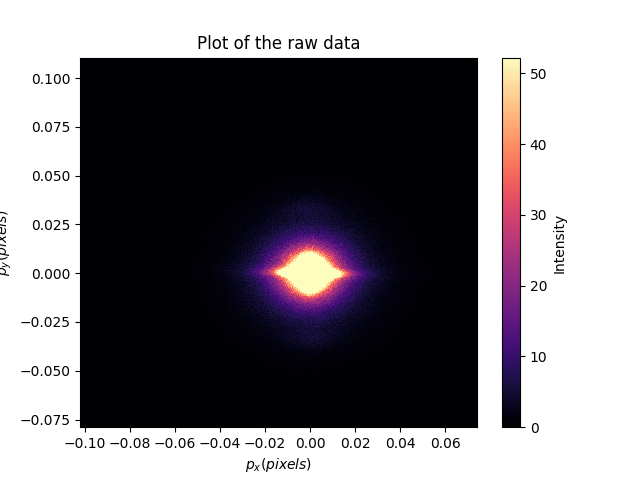

In [5]:
# Open your file
nx_file = NexusFile(file_path)

# Extract the datasets (the method extract datasets by default)
array_q = nx_file.extract_from_h5(path="ENTRY/DATA_Q_SPACE/Q")
array_intensity = nx_file.extract_from_h5(path="ENTRY/DATA_Q_SPACE/I")

# Plot using matplotlib
fig, ax = plt.subplots()
plot = ax.pcolormesh(array_q[:,:,0], array_q[:,:,1], array_intensity, vmin=0, vmax=np.percentile(array_intensity, 99), cmap="magma")

ax.set_title("Plot of the raw data")
ax.set_xlabel("$p_{x} (pixels)$")
ax.set_ylabel("$p_{y} (pixels)$")

cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Intensity")

nx_file.close()

# More processing options

If you want to do more processing to your file you can do the following :
1. Open a Nexus file with the NexusFile class. Be sure to include the path to the file in the parameter.
2. You can use one of these methods on the file :
    - .q_space(display=True|False, save=True|False, group_name=string)
    - .caking(display=True|False, save=True|False, group_name=string)
    - .radial_average(r_range=\[$r_{min}$, $r_{max}$\], angle_range=\[$\chi_{min}$, $\chi_{max}$\], display=True|False, save=True|False, group_name=string)
    - .horizontal_integration(qx_range=\[$qx_{min}$, $qx_{max}$\], qy_range=\[$qy_{min}$, $qy_{max}$\], display=True|False, save=True|False, group_name=string)
    - .vertical_integration(qx_range=\[$qx_{min}$, $qx_{max}$\], qy_range=\[$qy_{min}$, $qy_{max}$\], display=True|False, save=True|False, group_name=string)
3. each of the methods corresponds to the processing step it's named after. If you put display=True, it will show the graph, if you put save=True, it will save the processing step in the original .h5 file with the group "group_name". Both are False by default and there is a default value to group_name

<IPython.core.display.Javascript object>


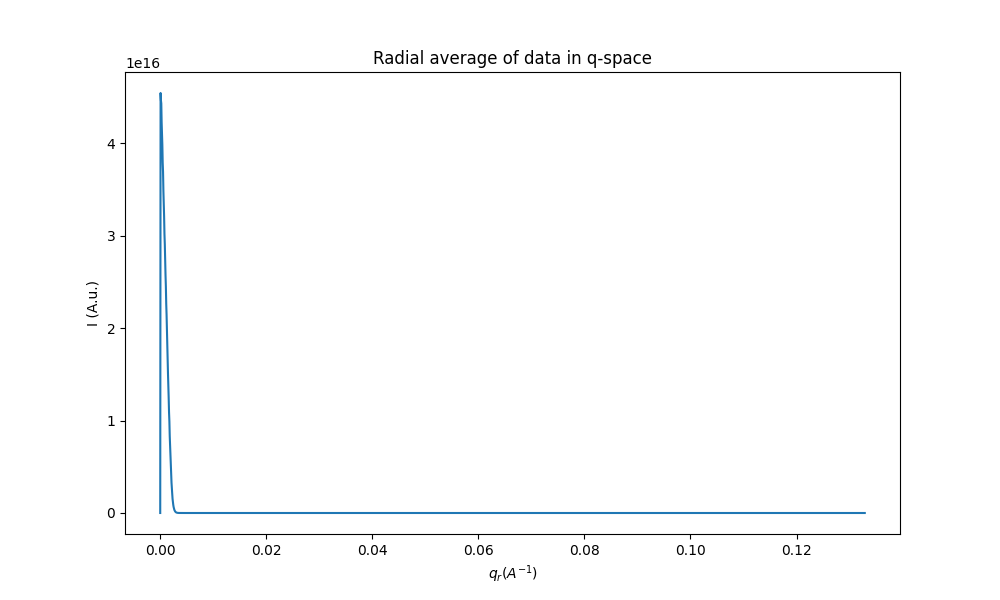

In [6]:
nx_file = NexusFile(file_path)
nx_file.radial_average(display=True, save=True)
nx_file.close()

# Post processing

In case you have results that aren't the way you want them to be, you can always change them or do another processing step by doing the following :

<IPython.core.display.Javascript object>


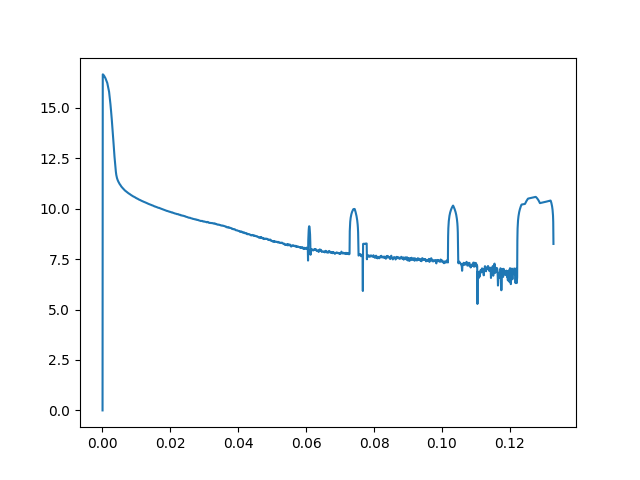

In [7]:
# We extract the dataset we just saved after checking where it's located in the .h5 file and close the file
nx_file = NexusFile(file_path)
actual_file = nx_file.get_file()
array_qr = nx_file.extract_from_h5(path="ENTRY/DATA_RAD_AVG/Q")
array_i = nx_file.extract_from_h5(path="ENTRY/DATA_RAD_AVG/I")

# Let's say we prefer to have the log base 10 of the intensity
array_i = np.log10(abs(array_i))

# We do a quick check to see if the scale is appropriate.
plt.figure()
plt.plot(array_qr, array_i)
plt.show()
nx_file.close()

In [8]:
# The interesting values seem to be in the range [0.00015, 0.006]
# first we use the method without saving so we can change the original range to this one and save it
nx_file = NexusFile(file_path)
nx_file.radial_average(r_range=[0.00015, 0.006], display=False, save=True)
nx_file.close()

<IPython.core.display.Javascript object>


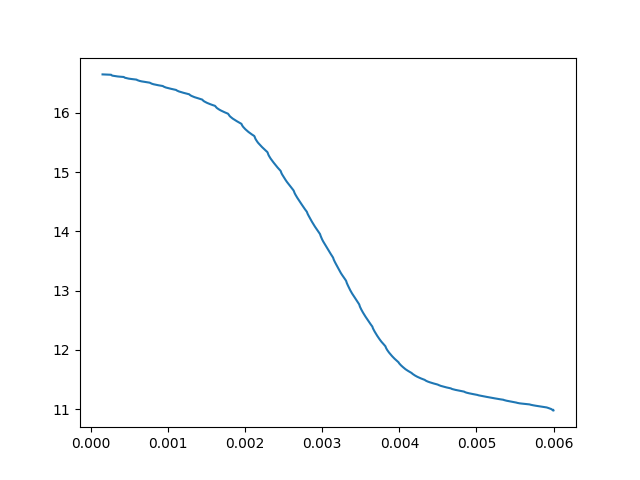

In [9]:
# We then do the exact same steps, only this time, we'll have the proper range
nx_file = NexusFile(file_path)

array_qr = nx_file.extract_from_h5(path="ENTRY/DATA_RAD_AVG/Q")
array_i = nx_file.extract_from_h5(path="ENTRY/DATA_RAD_AVG/I")

array_i = np.log10(abs(array_i))

# We do a quick check to see if the scale is indeed appropriate.
plt.figure()
plt.plot(array_qr, array_i)
plt.show()

In [10]:
# Looks good, we can save now 
# Using the same name will overwrite the existing data
nx_file.save_data(parameter_symbol="Q", parameter=array_qr, dataset_name="DATA_RAD_AVG", dataset=array_i)
nx_file.close()

# Batch processing
To batch process files you can simply fill the variable folder_path and put the processing you want, as an ewample we do some caking on waxs data

<IPython.core.display.Javascript object>


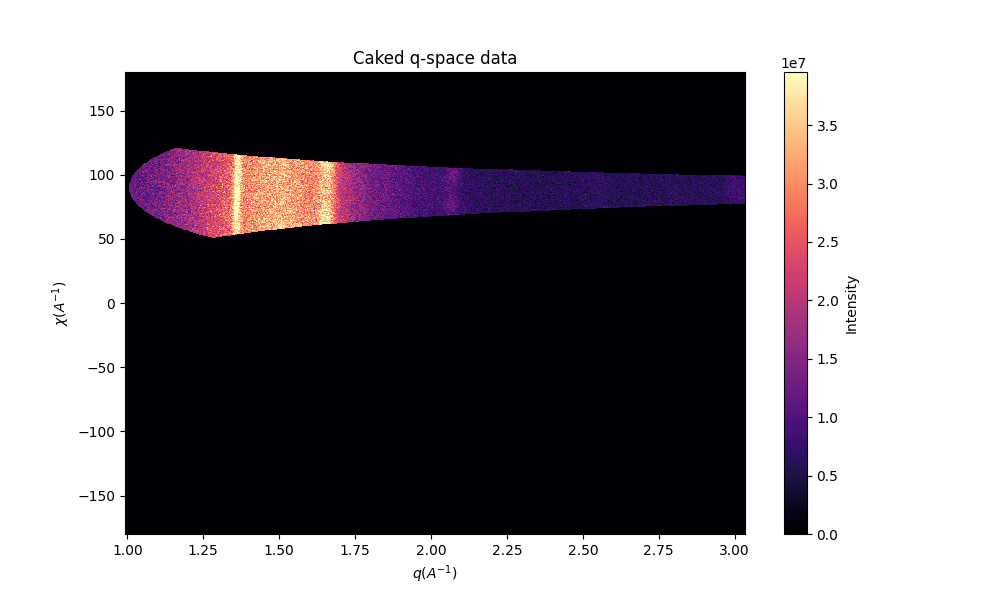

<IPython.core.display.Javascript object>


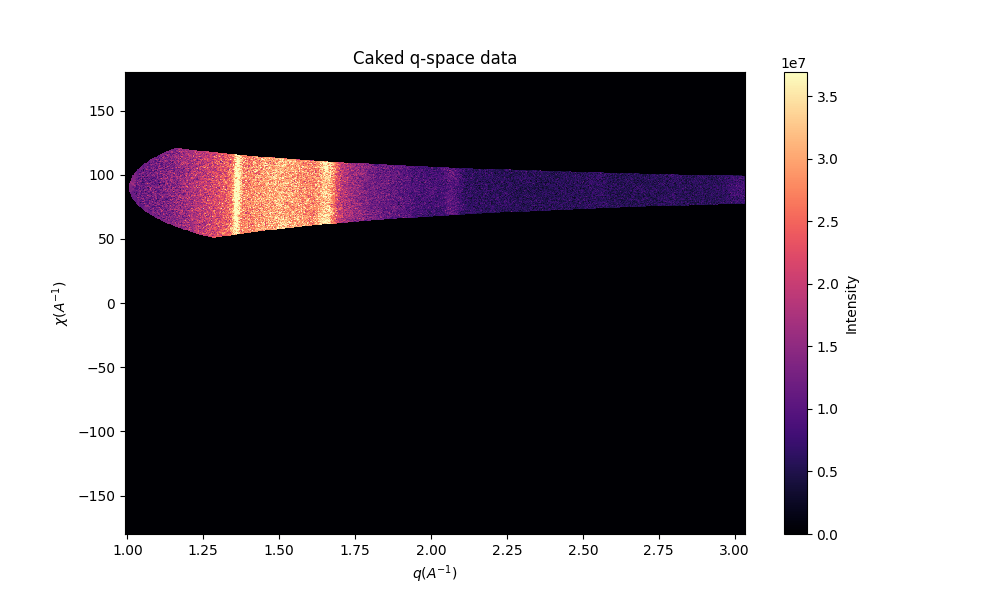

In [11]:
folder_path = "C:\\Users\\AT280565\\PycharmProjects\\EdfToHdf5\\edf2NxSAS\\treated data\\instrument - Xeuss\\config - 2024-12-19T15-00\\sample - SafeLiMove"

def find_hdf5_files(directory):
    """
    Recursively finds hdf5 files in the selected directory
    """
    hdf5_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".h5"):
                hdf5_files.append(os.path.join(root, file))
    return hdf5_files

files = find_hdf5_files(folder_path)

for file_path in files:
    nx_file = NexusFile(file_path)
    if "WAXS" in file_path:
        nx_file.caking(save=True, display=True)
    nx_file.close()
    